<a href="https://colab.research.google.com/github/AyeshaAnzer1610/Fairness-and-Bias-for-Responsible-AI-in-Engineering-Systems/blob/main/Case_Study_1_Fair_Load_Forecasting_Across_Grid_Regions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, time, itertools, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:
DATA_PATH = "/content/time_series_60min_singleindex.csv"
if not os.path.exists(DATA_PATH):
    DATA_PATH = "/mnt/data/time_series_60min_singleindex.csv"

COLS = {
    "DE_load_actual_entsoe_transparency": "urban",
    "FR_load_actual_entsoe_transparency": "suburban",
    "DK_load_actual_entsoe_transparency": "rural",
}

SPLIT_DATE = "2016-01-01"
LAG = 24
SEQ = 24
EPOCHS = 4      # fast + sufficient
BATCH = 256
LR = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def regional_mae(y_true, y_pred, regions):
    out = {}
    for r in np.unique(regions):
        idx = regions == r
        out[r] = mean_absolute_error(y_true[idx], y_pred[idx])
    return out

def max_disparity(maes):
    return max(abs(a-b) for a,b in itertools.permutations(maes.values(),2))


In [4]:
df = pd.read_csv(DATA_PATH, parse_dates=["utc_timestamp"])
df["utc_timestamp"] = df["utc_timestamp"].dt.tz_convert(None)

records = []
for col, reg in COLS.items():
    tmp = df[["utc_timestamp", col]].dropna().copy()
    tmp.columns = ["timestamp", "load"]
    tmp["region"] = reg
    records.append(tmp)

data = pd.concat(records).sort_values(["region","timestamp"]).reset_index(drop=True)

#  Downsample to 3-hourly (FAST)
data = (
    data.set_index("timestamp")
        .groupby("region")
        .resample("3H")
        .mean()
        .reset_index()
)

# Ensure 'load' column has no NaNs after resampling for consistent processing
data = data.dropna(subset=['load']).reset_index(drop=True)

train = data[data["timestamp"] < SPLIT_DATE]
test  = data[data["timestamp"] >= SPLIT_DATE]

In [5]:
def add_lags(df, lag=LAG):
    df = df.sort_values(["region","timestamp"]).copy()
    for l in range(1, lag+1):
        df[f"lag_{l}"] = df.groupby("region")["load"].shift(l)
    return df.dropna()

train_lag = add_lags(train)
test_lag  = add_lags(test)

X_COLS = [c for c in train_lag.columns if c.startswith("lag_")]

Y_EVAL  = test_lag["load"].values
REG_EVAL = test_lag["region"].values

In [6]:
results = []

def log_result(name, y_true, y_pred, regions, t):
    maes = regional_mae(y_true, y_pred, regions)
    results.append({
        "Model": name,
        "Urban MAE": maes["urban"],
        "Suburban MAE": maes["suburban"],
        "Rural MAE": maes["rural"],
        "Max Disp.": max_disparity(maes),
        "Avg MAE": mean_absolute_error(y_true, y_pred),
        "Latency (s)": t
    })

In [7]:
# Naive
t0 = time.time()
log_result("Naive (t-1)", Y_EVAL, test_lag["lag_1"].values, REG_EVAL, time.time()-t0)

def run_ml(name, model):
    pipe = Pipeline([("scaler",StandardScaler()),("model",model)])
    t0 = time.time()
    pipe.fit(train_lag[X_COLS], train_lag["load"])
    pred = pipe.predict(test_lag[X_COLS])
    log_result(name, Y_EVAL, pred, REG_EVAL, time.time()-t0)

run_ml("Ridge", Ridge())
run_ml("SVR", SVR(C=10))
run_ml("KNN", KNeighborsRegressor(10))
run_ml("RF", RandomForestRegressor(100,n_jobs=-1))
run_ml("GBRT", GradientBoostingRegressor())
run_ml("MLP", MLPRegressor((128,64),max_iter=300))

In [8]:
# Compute scaling from TRAIN only (no leakage)
load_mean = train["load"].mean()
load_std  = train["load"].std()

class SeqDataset(Dataset):
    def __init__(self, df):
        self.X, self.y, self.reg = [], [], []
        for r in df["region"].unique():
            vals = df[df["region"]==r]["load"].values
            vals = (vals - load_mean) / load_std   # ✅ NORMALIZATION
            for i in range(SEQ, len(vals)):
                self.X.append(vals[i-SEQ:i])
                self.y.append(vals[i])
                self.reg.append(r)

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)
        self.reg = np.array(self.reg)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i], self.reg[i]

In [9]:
LAMBDA_LIST = [0.0, 0.05, 0.1, 0.25, 0.5]

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1,64,batch_first=True)
        self.fc = nn.Linear(64,1)
    def forward(self,x):
        x = x.unsqueeze(-1)
        _,(h,_) = self.lstm(x)
        return self.fc(h[-1]).squeeze()

REG2ID = {"urban":0,"suburban":1,"rural":2}

In [10]:
def run_lstm(name, mode="standard", lam=0.5):
    model = LSTM().to(DEVICE)
    tr = DataLoader(SeqDataset(train.dropna(subset=['load'])),batch_size=BATCH,shuffle=True)
    te = DataLoader(SeqDataset(test.dropna(subset=['load'])),batch_size=BATCH)
    opt = torch.optim.Adam(model.parameters(),lr=LR)
    mse = nn.MSELoss()

    t0 = time.time()
    for _ in range(EPOCHS):
        for x,y,reg in tr:
            x,y = x.to(DEVICE),y.to(DEVICE)
            p = model(x)
            if mode=="standard":
                loss = mse(p,y)
            else:
                abs_err = torch.abs(p-y)
                gids = torch.tensor([REG2ID[r] for r in reg],device=DEVICE)
                gmae = [abs_err[gids==i].mean() for i in range(3) if (gids==i).any()]
                gmae = torch.stack(gmae)
                loss = mse(p,y)+lam*(gmae.max()-gmae.min()) if mode=="fair" else gmae.max()
            opt.zero_grad(); loss.backward(); opt.step()

    preds,regs = [],[]
    with torch.no_grad():
        for x,y,reg in te:
            preds.append(model(x.to(DEVICE)).cpu().numpy())
            regs+=list(reg)

    preds = np.concatenate(preds) # Concatenate predictions first
    preds = preds * load_std + load_mean # Then denormalize
    pred_series = pd.Series(preds[:len(test_lag.index)], index=test_lag.index)
    log_result(name, Y_EVAL, preds[:len(Y_EVAL)], REG_EVAL, time.time()-t0)

run_lstm("LSTM")
for lam in LAMBDA_LIST:
    name = "LSTM (λ=0)" if lam == 0 else f"FairReg LSTM (λ={lam})"
    run_lstm(name, mode="fair", lam=lam)
run_lstm("Worst-Case Optimized LSTM",mode="worst")

                        Model    Urban MAE  Suburban MAE    Rural MAE  \
4                          RF  1103.736756   1166.744334    94.869789   
1                       Ridge  1375.456587   1190.342425   117.364935   
6                         MLP  1336.705900   1275.635677   261.138566   
5                        GBRT  1487.354483   1552.270975   276.314611   
3                         KNN  1635.125355   1820.496607   116.200569   
0                 Naive (t-1)  5118.691926   3554.186323   414.687265   
7                        LSTM  7213.245656   4401.188158   649.449625   
8                  LSTM (λ=0)  7296.175026   4665.187014   575.615896   
9       FairReg LSTM (λ=0.05)  7248.973014   4371.261927  1825.721633   
10       FairReg LSTM (λ=0.1)  7161.149042   4515.427116  3670.714511   
11      FairReg LSTM (λ=0.25)  7191.655895   4797.176661  4745.900229   
13  Worst-Case Optimized LSTM  7136.414351   5178.953190  5963.294900   
12       FairReg LSTM (λ=0.5)  7326.691146   5865.0

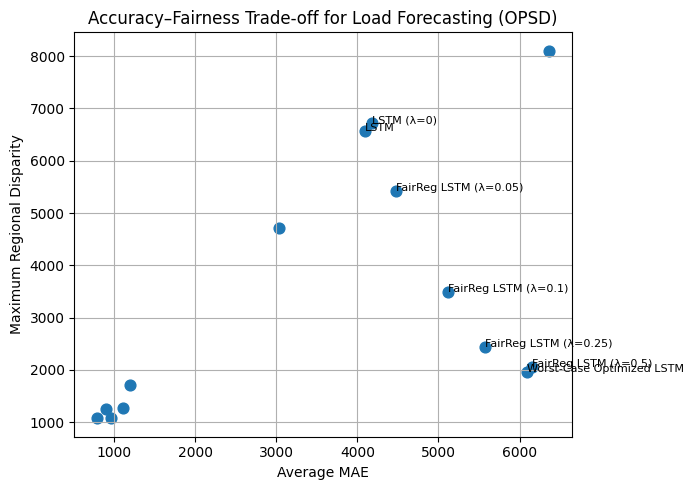

In [11]:
df_results = pd.DataFrame(results).sort_values("Avg MAE")
print(df_results)

plt.figure(figsize=(7,5))

# plot all models
plt.scatter(df_results["Avg MAE"], df_results["Max Disp."], s=60)

# annotate only key models (avoid clutter)
for _, r in df_results.iterrows():
    if "λ=" in r["Model"] or r["Model"] in ["LSTM", "Worst-Case Optimized LSTM"]:
        plt.text(
            r["Avg MAE"], r["Max Disp."],
            r["Model"],
            fontsize=8
        )

plt.xlabel("Average MAE")
plt.ylabel("Maximum Regional Disparity")
plt.title("Accuracy–Fairness Trade-off for Load Forecasting (OPSD)")
plt.grid(True)
plt.tight_layout()
plt.show()
